**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model using word embeddings, and (if appropriate) apply additional feature engineering
* Train your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* Using your model, rank the top 10 words associated with real news articles and fake news articles
* *Answer the following question*: what is 1 idea that you have to improve your model's performance on this dataset (you don't have to implement it)


<b>Further Improvement to the Model:</b>

1. Bert and its variants have been found to give SOTA performance on many text classification tasks. A bert based model (DistillBert, RobertA etc.) could give better performances as compared to the model implemented in the current notebook.

2. We can also investigate the performance of the model when we use features such as 
    - word/sentence count of a news article
    - average sentence length
    - sentiment
    - average word length
    - count of NER tags
    - Bigrams

3. As seen from the notebook, even very basic algorithms like logistic regression is performing very well on the given data. This made me question if there were certain features that exist only in True news or Fake news. If such features existed, the model would easily classify between true and fake news. In section 6, we saw that may news in the dataset are duplcicate. Also, there are many words that solely occur in either true/fake data. Upon correcting it, the model performance did decrease marginally. There could be many such data leaks in the dataset which can be investigated further. 


# 1. Import Libraries

In [ ]:
!pip3 install emoji lime wandb

In [127]:
""" Importing Libraries """

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
import re
import pickle
import emoji 
import unicodedata
import wandb
from wandb.keras import WandbCallback
wandb.init(config={"hyper": "parameter"})
from tqdm import tqdm 
import nltk
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, plot_roc_curve, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns 

from sklearn.pipeline import make_pipeline
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

nltk.download('stopwords')
from nltk.corpus import stopwords

%matplotlib inline

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1454, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1611, in _on_finish
    self._backend.interface.publish_telemetry(self._telemetry_obj)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 225, in publish_telemetry
    self._publish(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 517, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Data

In [2]:
""" Loading data """

true_data = pd.read_csv(os.getcwd() + '/True.csv')
fake_data = pd.read_csv(os.getcwd() + '/Fake.csv')
print(true_data.shape, fake_data.shape)
print(true_data.columns)

(21417, 4) (23481, 4)
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [ ]:
true_data['label'] = 1
fake_data['label'] = 0

full_data = pd.concat([true_data, fake_data])
full_data = full_data.drop(['date'], axis=1)

# 3. Preprocessing

The following section performs some preprocessing on the title and text column. 

In [46]:
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not',"Don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not',"They're":'they are','don’t': 'do not','Don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is',"He's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"I'd": 'i would',"i'll": 'i will',"I'll": 'i will',"i'm": 'i am',"I'm": 'i am',"i've": 'i have',"I've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',"It's":'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am','I’m': 'i am',
    'i’ve': 'i have','I’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have',"We've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have','We’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop'," :‑)":'smiley',\
    " :)":'smiley'," :-]":'smiley'," :]":'smiley'," :‑D":'laughing'," :D":'laughing'," =D":'laughing'," :‑(":'sad'," :(":'sad'," ;)":'wink'," :P":'cheeky', "he'll've":"he will have",
    "how'd'y":"how do you", "i'd've":"i would have","i'll've":"i will have","it'd've":"it would have", "it'll've":"it will have", "mightn't've":"might not have",
    "mustn't've":"must not have", "needn't've":"need not have", "o'clock":"of the clock", "oughtn't've":"ought not have", "shan't've":"shall not have", "she'd've":"she would have",
    "she'll've":"she will have", "shouldn't've":"should not have", "so've":"so have", "so's":"so is", "that'd've":"that would have", "there'd've":"there would have",
    "they'd've":"they would have", "they'll've":"they will have", "to've":"to have", "we'd've":"we would have", "we'll've":"we will have", "what'll've":"what will have",
    "when's":"when is", "when've":"when have", "where've":"where have", "who'll've":"who will have", "why's":"why is", "why've":"why have", "will've":"will have", "won't've":"will not have",
    "wouldn't've":"would not have", "y'alls":"you alls", "y'all'd":"you all would", "y'all'd've":"you all would have", "y'all're":"you all are", "y'all've":"you all have", "you'd've":"you would have", "you'll've":"you will have",
    }

In [47]:
special_characters = {
    "’": "'", "‘": "'", "´": "'", "`": "'", "…": "...", "&": " and ", "“": '"', "”": '"',
    "⁰": "0", "¹": "1", "²": "2", "³": "3", "⁴": "4", "⁵": "5", "⁶": "6", "⁷": "7", "⁸": "8", "⁹": "9",
    "₀": "0", "₁": "1", "₂": "2", "₃": "3", "₄": "4", "₅": "5", "₆": "6", "₇": "7", "₈": "8", "₉": "9", 
    "ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", 
    "ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m", "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", 
    "s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z"
}

In [48]:
def remove_whitespace(text):
    """remove whitespaces from text"""

    text = text.strip()
    return " ".join(text.split())

punctuations = string.punctuation

def remove_punctuation(text):
  """ function to remove punctuations """

  return text.translate(str.maketrans('', '', punctuations))

def replace_usernames(text, filler='user'):
    """ To remove twitter handles """

    username_regex = re.compile(r'(^|[^@\w])@(\w{1,15})\b')

    text = text.replace('@<user>', f'{filler}')

    text = re.sub(username_regex, filler, text)

    text = text.replace(filler, f' {filler} ')

    text = ' '.join(text.split())

    return text
  
def replace_urls(text, filler='url'):

    """ replacing urls """

    url_regex = re.compile(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))')

    text = text.replace('<url>', filler)

    text = re.sub(url_regex, filler, text)

    text = text.replace(filler, f' {filler} ')

    text = ' '.join(text.split())

    return text

def expand_contractions(text,contraction_mapping):
  """ expanding contractions """

  for i in contraction_mapping:
    if i in text:
      text = text.replace(i, contraction_mapping[i])

  return text

def replace_special_characters(text, special_characters):
  special_characters_re = re.compile('({})'.format('|'.join(special_characters.keys())))
  special_characters_map = lambda match: special_characters[match.group(0)]
  
  text = special_characters_re.sub(special_characters_map, text)
  return text


with open('/content/Emoji_Dict.p', 'rb') as fp:
  Emoji_Dict = pickle.load(fp)

Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def replace_remove_emoji(text, Emoji_Dict):
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F" # emoticons
                          u"\U0001F300-\U0001F5FF" # symbols & pictographs
                          u"\U0001F680-\U0001F6FF" # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  
  for emo in Emoji_Dict:
    if emo in text:
      text = re.sub(r'('+emo+')', "_".join(Emoji_Dict[emo].replace(",","").replace(":","").split()), text)
  
  text = emoji.get_emoji_regexp().sub(u'', text) 

  return text

def strip_chinese(string):
  en_list = re.findall(u'[^\u4E00-\u9FA5]', string)
  for c in string:
    if c not in en_list:
      string = string.replace(c, '')
  return string

stopword = set(stopwords.words('english'))
def remove_stopwords(text, stopword):
    """function to remove the stopwords"""

    return " ".join([word for word in str(text).split() if word not in stopword])

def remove_accents(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text
  

In [49]:
def data_preprocessing(text, contraction_mapping, stopword, special_characters, Emoji_Dict, 
                       lowercase=True, punctuations=True, usernames=True, urls=True,  
                       contractions=True, special_chars=True, emoji=True, chinese=True, 
                       stop_words=True, accented_chars=True, extra_whitespace=True):

  if lowercase == True: #convert all characters to lowercase
    text = text.lower()
  
  if extra_whitespace == True: 
    text = remove_whitespace(text)
        
  if accented_chars == True: #replaced accented characters
    text = remove_accents(text)

  if chinese  == True:
    text = strip_chinese(text)

  if contractions == True: #expand contractions
    text = expand_contractions(text, contraction_mapping)

  if emoji == True:
    text = replace_remove_emoji(text, Emoji_Dict)

  if stop_words == True:
    text = remove_stopwords(text, stopword)

  if special_chars == True: 
    text = replace_special_characters(text, special_characters)

  if punctuations == True:
    text = remove_punctuation(text)

  if usernames == True:
    text = replace_usernames(text)

  if urls == True:
    text = replace_urls(text)

  return text


In [ ]:
text = full_data['text'].values
title = full_data['title'].values

for i in tqdm(range(full_data.shape[0])):
  title[i] = data_preprocessing(title[i], contraction_mapping, stopword, special_characters, Emoji_Dict)

for i in tqdm(range(full_data.shape[0])):
  text[i] = data_preprocessing(text[i], contraction_mapping, stopword, special_characters, Emoji_Dict)

full_data['modified_title'] = title
full_data['modified_text'] = text

full_data.to_csv('/content/full_data.csv', index=False, columns=list(full_data.columns))

In [8]:
full_data = pd.read_csv('/content/full_data.csv')
full_data['combined'] = full_data['title'] + " " + full_data['text'] 
full_data = full_data.dropna()

# 4. Pre-analysis

The following section shows the distribution of real and fake news and its subjects. 

## 4.1 Distribution of True/Fake News

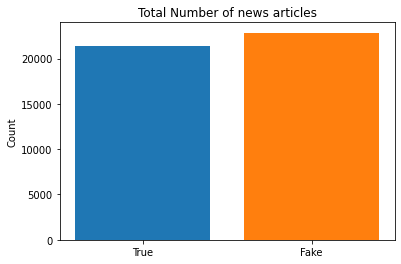

In [9]:
true_data = full_data[full_data['label']== 1]
fake_data = full_data[full_data['label']== 0]

plt.ylabel('Count')
plt.title('Total Number of news articles')
plt.bar(x='True', height=true_data.shape[0])
plt.bar(x='Fake', height=fake_data.shape[0])
plt.show()

## 4.2 Distribution of Subjects


<b>Note: True and Fake news belong to completely separate subjects. Hence, it cannot be used as a feature. </b>

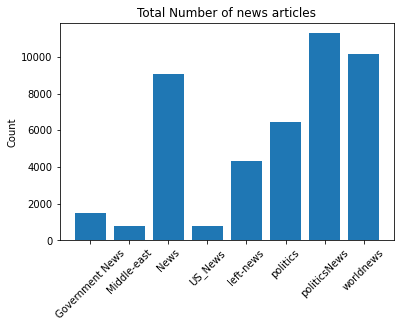

In [10]:
subject_count = full_data.groupby('subject').apply(lambda z:z['text'].count())

plt.ylabel('Count')
plt.title('Total Number of news articles')
plt.bar(x=subject_count.keys(),  height=subject_count.values)
plt.xticks(rotation = 45)

plt.show()

In [175]:
subject_count = full_data.groupby(['subject', 'label']).count()
lis = list(subject_count.index)

[]

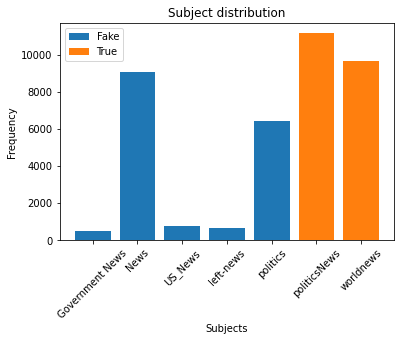

In [188]:
plt.figure()
plt.bar(x = [i[0] for i in lis if i[1]==0], label='Fake', height = [int(subject_count.loc[i].values[0]) for i in lis if i[1]==0])
plt.bar(x = [i[0] for i in lis if i[1]==1], label='True', height = [int(subject_count.loc[i].values[0]) for i in lis if i[1]==1])

plt.xticks(rotation = 45)
plt.xlabel('Subjects')
plt.ylabel('Frequency')
plt.title('Subject distribution')
plt.legend()
plt.plot()

# 5. Model

I have experimented with 2 different models. 
1. Logistic Regression model (Section 5.1)
2. LSTM based model (Section 5.2)

## 5.1 Baseline-1: Logistic Regression

In [11]:
""" Params """

test_train_split=0.8

In [12]:
def get_train_test(full_data, feature, test_train_split):
  """ Get train-test splits """

  if feature == 'title':
    X = full_data['title']
  elif feature == 'text':
    X = full_data['text']
  elif feature == 'both':
    X = full_data['combined']
  
  Y = full_data['label']
  train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=(1-test_train_split),random_state=2)
  return train_x, test_x, train_y, test_y

def get_vectors(train_x, test_x):  
  """ Get train-test vectors """

  train_vector = CountVectorizer().fit(train_x)
  train_vector_x = train_vector.transform(train_x)
  test_vector_x = train_vector.transform(test_x)

  return train_vector, train_vector_x, test_vector_x

### ***1. Considering only title***

0.9403372404753301


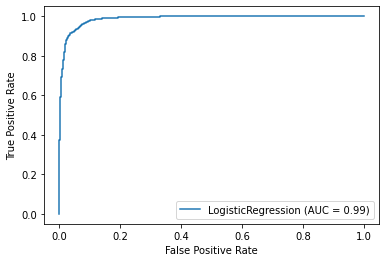

In [ ]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'title', test_train_split)
train_vector, train_vector_x, test_vector_x = get_vectors(train_x, test_x)

baseline_model_1 = LogisticRegression(C=2, max_iter=200)
baseline_model_1.fit(train_vector_x, train_y)
preds= baseline_model_1.predict(test_vector_x)
acc = roc_auc_score(test_y, preds)
print(acc)

plot_roc_curve(baseline_model_1, test_vector_x, test_y)
plt.show()

### ***2. Considering only Text***

0.9951889830462762


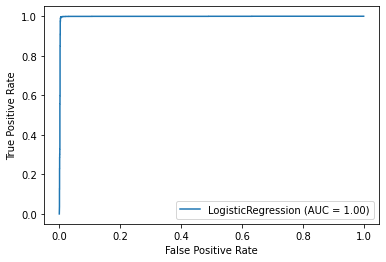

In [ ]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'text', test_train_split)
train_vector, train_vector_x, test_vector_x = get_vectors(train_x, test_x)

baseline_model_1 = LogisticRegression(C=2, max_iter=200)
baseline_model_1.fit(train_vector_x, train_y)
preds= baseline_model_1.predict(test_vector_x)
acc = roc_auc_score(test_y, preds)
print(acc)

plot_roc_curve(baseline_model_1, test_vector_x, test_y)
plt.show()

### ***3. Considering both Title + text***

0.9950485336080739


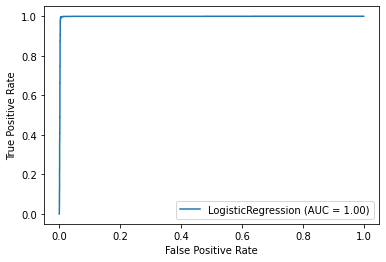

In [ ]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'both', test_train_split)
train_vector, train_vector_x, test_vector_x = get_vectors(train_x, test_x)

baseline_model_1 = LogisticRegression(C=2, max_iter=200)
baseline_model_1.fit(train_vector_x, train_y)
preds= baseline_model_1.predict(test_vector_x)
acc = roc_auc_score(test_y, preds)
print(acc)

plot_roc_curve(baseline_model_1, test_vector_x, test_y)
plt.show()

## 5.2 LSTM Based Model

In [19]:
""" Params """

max_vocab = 10000
maxlen = 256
test_train_split = 0.8
val_split = 0.1
batch_size=32
lr=1e-4

In [20]:
def get_tokeizer(max_vocab, maxlen, train_x, test_x):
  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(train_x)

  train_x = tokenizer.texts_to_sequences(train_x)
  test_x = tokenizer.texts_to_sequences(test_x)

  train_x = tf.keras.preprocessing.sequence.pad_sequences(train_x, padding='post', maxlen=maxlen)
  test_x = tf.keras.preprocessing.sequence.pad_sequences(test_x, padding='post', maxlen=maxlen)

  return train_x, test_x


In [23]:
def get_model(max_vocab, lr):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(max_vocab, 32),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #return_sequences=True
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(lr),
                metrics=['accuracy'])
  
  return model

def plot_metrics(history):

  """ Plotting model Loss and Accuracy Curves"""

  hist_dict = history.history

  acc = hist_dict['accuracy']
  val_acc = hist_dict['val_accuracy']
  loss = hist_dict['loss']
  val_loss = hist_dict['val_loss']
  epochs = history.epoch

  plt.figure()
  plt.plot(epochs, loss, 'r', label='Train loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, acc, 'g', label='Train accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.ylim((0.5,1))
  plt.show()

def plot_auc(test_y, output):

  """ Plotting AUC curve """

  ns_probs = [0 for _ in range(len(output))]

  lr_fpr, lr_tpr, _ = roc_curve(y_true=test_y, y_score=output)
  ns_fpr, ns_tpr, _ = roc_curve(y_true=test_y, y_score=ns_probs)

  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Baseline2')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

def plot_confusion_matrix(test_y, output):

  """ Plotting confusion matrix """

  prediction = []

  for i in output:
    if i>=0.5:
      prediction.append(1)
    else:
      prediction.append(0)

  matrix = confusion_matrix(prediction, test_y)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(matrix, fmt = 'd', annot=True, ax = ax)

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels([0,1])
  ax.yaxis.set_ticklabels([0,1])

### ***1. Considering Title as feature***

In [24]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'title', test_train_split)
train_x, test_x = get_tokeizer(max_vocab, maxlen, train_x, test_x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_title = get_model(max_vocab, lr)
history = lstm_title.fit(train_x, train_y, epochs=7,validation_split=val_split, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, WandbCallback()] ,verbose=1)

Epoch 1/7
996/996 [==============================] - 28s 24ms/step - loss: 0.5815 - accuracy: 0.6223 - val_loss: 0.1990 - val_accuracy: 0.9297
Epoch 2/7
996/996 [==============================] - 22s 23ms/step - loss: 0.1818 - accuracy: 0.9324 - val_loss: 0.1519 - val_accuracy: 0.9458
Epoch 3/7
996/996 [==============================] - 23s 23ms/step - loss: 0.1218 - accuracy: 0.9546 - val_loss: 0.1343 - val_accuracy: 0.9387
Epoch 4/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0948 - accuracy: 0.9660 - val_loss: 0.1261 - val_accuracy: 0.9517
Epoch 5/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0686 - accuracy: 0.9753 - val_loss: 0.1221 - val_accuracy: 0.9514
Epoch 6/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0592 - accuracy: 0.9807 - val_loss: 0.1277 - val_accuracy: 0.9503
Epoch 7/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0512 - accuracy: 0.9823 - val_loss: 0.1341 - val_accuracy: 0.9529

In [25]:
lstm_title.evaluate(test_x, test_y)
output = lstm_title.predict(test_x)

277/277 [==============================] - 2s 8ms/step - loss: 0.1310 - accuracy: 0.9518


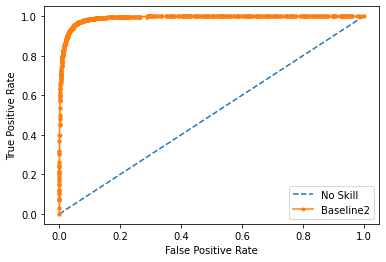

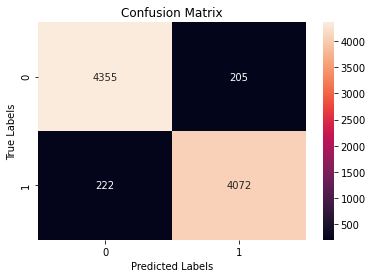

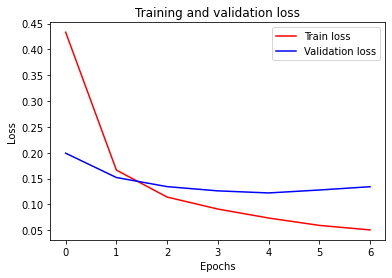

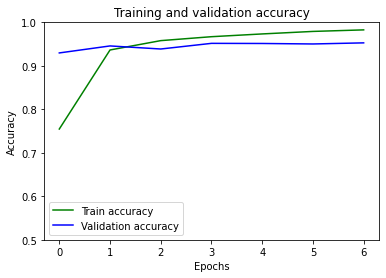

In [28]:
plot_auc(test_y, output)
plot_confusion_matrix(test_y, output)
plot_metrics(history)

### **2. Considering Text as only feature**

In [29]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'text', test_train_split)
train_x, test_x = get_tokeizer(max_vocab, maxlen, train_x, test_x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_text = get_model(max_vocab, lr)
history = lstm_text.fit(train_x, train_y, epochs=7,validation_split=val_split, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, WandbCallback()] ,verbose=1)

Epoch 1/7
996/996 [==============================] - 27s 24ms/step - loss: 0.4793 - accuracy: 0.6856 - val_loss: 0.0714 - val_accuracy: 0.9800
Epoch 2/7
996/996 [==============================] - 24s 24ms/step - loss: 0.0507 - accuracy: 0.9878 - val_loss: 0.0580 - val_accuracy: 0.9845
Epoch 3/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0240 - accuracy: 0.9945 - val_loss: 0.0309 - val_accuracy: 0.9896
Epoch 4/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.0307 - val_accuracy: 0.9924
Epoch 5/7
996/996 [==============================] - 23s 24ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.0310 - val_accuracy: 0.9918
Epoch 6/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0374 - val_accuracy: 0.9921


In [30]:
lstm_text.evaluate(test_x, test_y)
output = lstm_text.predict(test_x)

277/277 [==============================] - 3s 10ms/step - loss: 0.0260 - accuracy: 0.9923


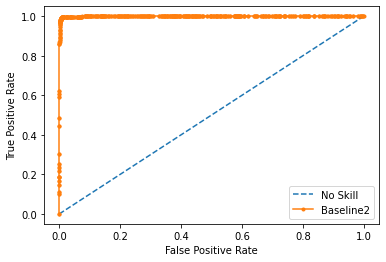

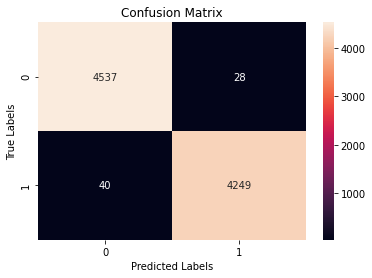

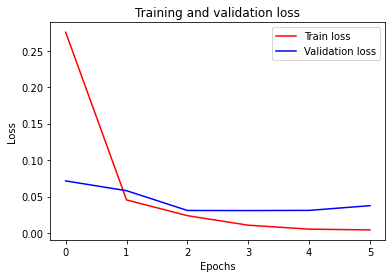

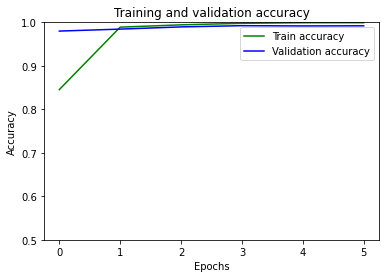

In [31]:
plot_auc(test_y, output)
plot_confusion_matrix(test_y, output)
plot_metrics(history)

### **3. Considering Title+Text as feature**

In [32]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'both', test_train_split)
train_x, test_x = get_tokeizer(max_vocab, maxlen, train_x, test_x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_combined = get_model(max_vocab, lr)
history = lstm_combined.fit(train_x, train_y, epochs=7,validation_split=val_split, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, WandbCallback()] ,verbose=1)

Epoch 1/7
996/996 [==============================] - 27s 24ms/step - loss: 0.4326 - accuracy: 0.7241 - val_loss: 0.0697 - val_accuracy: 0.9839
Epoch 2/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0405 - accuracy: 0.9903 - val_loss: 0.0461 - val_accuracy: 0.9867
Epoch 3/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0184 - accuracy: 0.9961 - val_loss: 0.0468 - val_accuracy: 0.9884
Epoch 4/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0310 - val_accuracy: 0.9910
Epoch 5/7
996/996 [==============================] - 23s 23ms/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0.0407 - val_accuracy: 0.9912
Epoch 6/7
996/996 [==============================] - 24s 24ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0429 - val_accuracy: 0.9918


In [33]:
lstm_combined.evaluate(test_x, test_y)
output = lstm_combined.predict(test_x)

277/277 [==============================] - 2s 9ms/step - loss: 0.0245 - accuracy: 0.9922


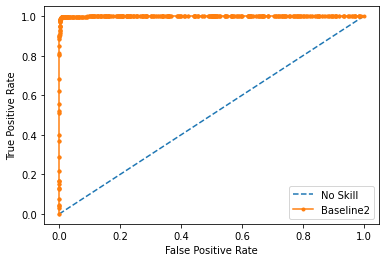

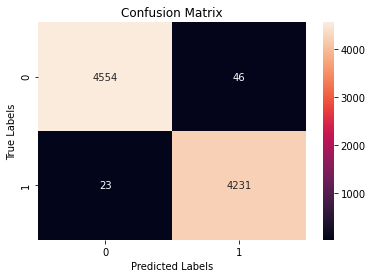

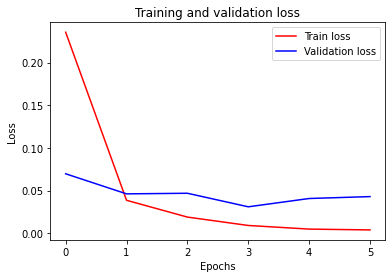

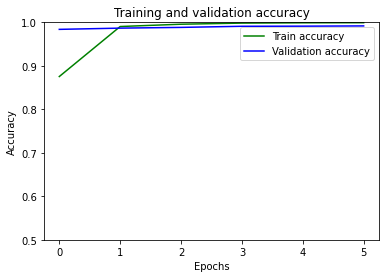

In [34]:
plot_auc(test_y, output)
plot_confusion_matrix(test_y, output)
plot_metrics(history)

# 6. Post-Analysis

For all the models, we are getting astonishingly high accuracies. Let's have a look at any possible reasons for this. 

## 6.1 Checking for Duplicate Rows

As seen there are a lot of duplicate title and text in true and fake data. The performance of the LSTM (title + text) model decreased marginally. Hence, this was one of the reasons for high performance of the model.


In [138]:
full_data = pd.read_csv('/content/full_data.csv')
full_data['combined'] = full_data['title'] + " " + full_data['text'] 
full_data = full_data.dropna()

In [139]:
true_data = full_data[full_data['label'] == 1]
fake_data = full_data[full_data['label'] == 0]

# duplicated title - 591
num_true_title_duplicates = true_data.duplicated(subset=['title']).sum()

# duplicated text - 225
num_true_text_duplicates = true_data.duplicated(subset=['text']).sum()

# duplicated title - 5578
num_fake_title_duplicates = fake_data.duplicated(subset=['title']).sum()

# duplicated text - 6026
num_fake_text_duplicates = fake_data.duplicated(subset=['text']).sum()

## title common to both true and fake
common_title = true_data[true_data['title'].isin(fake_data['title'])].shape

# text common to both true and fake
common_text = true_data[true_data['text'].isin(fake_data['text'])].shape

print(num_true_title_duplicates)
print(num_true_text_duplicates)
print(num_fake_title_duplicates)
print(num_fake_text_duplicates)
print(common_title)
print(common_text)

603
249
5396
5404
(0, 8)
(0, 8)


In [140]:
# Performance After
full_data = full_data.drop_duplicates(['text'])
full_data = full_data.drop_duplicates(['title'])

In [141]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'text', test_train_split)
train_x, test_x = get_tokeizer(max_vocab, maxlen, train_x, test_x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_combined_without_duplicates = get_model(max_vocab, lr)
history = lstm_combined_without_duplicates.fit(train_x, train_y, epochs=7,validation_split=val_split, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, WandbCallback()] ,verbose=1)

Epoch 1/7
861/861 [==============================] - 25s 26ms/step - loss: 0.5061 - accuracy: 0.6473 - val_loss: 0.0800 - val_accuracy: 0.9771
Epoch 2/7
861/861 [==============================] - 21s 25ms/step - loss: 0.0770 - accuracy: 0.9805 - val_loss: 0.0429 - val_accuracy: 0.9866
Epoch 3/7
861/861 [==============================] - 22s 25ms/step - loss: 0.0369 - accuracy: 0.9912 - val_loss: 0.0362 - val_accuracy: 0.9918
Epoch 4/7
861/861 [==============================] - 21s 25ms/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 0.0298 - val_accuracy: 0.9931
Epoch 5/7
861/861 [==============================] - 22s 25ms/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 0.0267 - val_accuracy: 0.9931
Epoch 6/7
861/861 [==============================] - 21s 25ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0252 - val_accuracy: 0.9944
Epoch 7/7
861/861 [==============================] - 21s 25ms/step - loss: 0.0051 - accuracy: 0.9993 - val_loss: 0.0242 - val_accuracy: 0.9944

In [142]:
lstm_combined_without_duplicates.evaluate(test_x, test_y)
output = lstm_combined_without_duplicates.predict(test_x)

240/240 [==============================] - 2s 9ms/step - loss: 0.0313 - accuracy: 0.9923


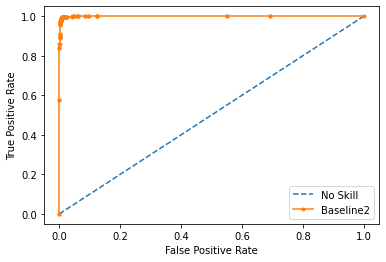

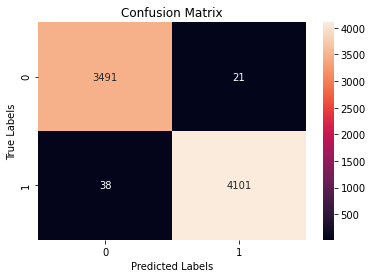

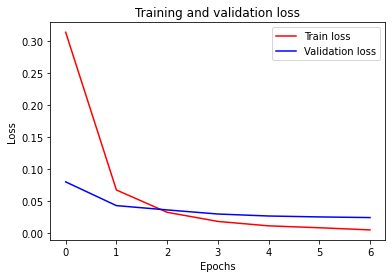

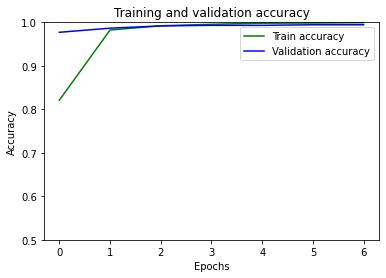

In [143]:
plot_auc(test_y, output)
plot_confusion_matrix(test_y, output)
plot_metrics(history)

## 6.2 Impact of Certain words on Model accuracy

It can be seen that the term 'washington' and 'reuters' occur on almost every True news. By removing certain words such as ['reuters', 'washington','donald', 'said'], the model's accuracy decreased. This is because the distribution of the words are not similar amongst the two classes.

In [144]:
# Lets what are the most common words in True data

true_data = full_data[full_data['label']==1]['modified_text']

word_dict_true = {}
for news in true_data:
  for word in news.split(' '):
    if word in word_dict_true:
      word_dict_true[word]+=1
    else:
      word_dict_true[word]=1
  
most_frequent_true = sorted(word_dict_true, key=word_dict_true.get, reverse=True)

# Lets what are the most common words in True data

fake_data = full_data[full_data['label']==0]['modified_text']

word_dict_fake = {}
for news in fake_data:
  for word in news.split(' '):
    if word in word_dict_fake:
      word_dict_fake[word]+=1
    else:
      word_dict_fake[word]=1

most_frequent_fake = sorted(word_dict_fake, key=word_dict_fake.get, reverse=True)

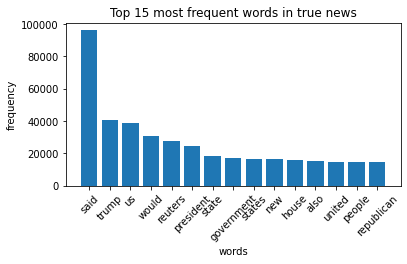

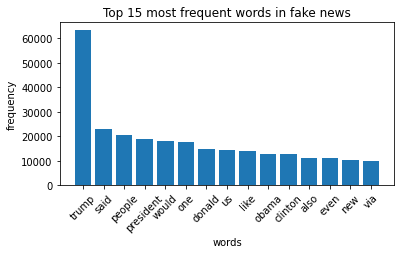

In [145]:
plt.figure(figsize=(6,3))
plt.bar(x = most_frequent_true[:15], height=[word_dict_true[i] for i in most_frequent_true[:15]])
plt.xticks(rotation = 45)
plt.xlabel('words')
plt.ylabel('frequency')
plt.title("Top 15 most frequent words in true news")
plt.show()

plt.figure(figsize=(6,3))
plt.bar(x = most_frequent_fake[:15], height=[word_dict_fake[i] for i in most_frequent_fake[:15]])
plt.xticks(rotation = 45)
plt.xlabel('words')
plt.ylabel('frequency')
plt.title("Top 15 most frequent words in fake news")
plt.show()

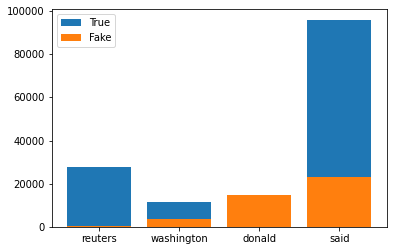

In [146]:
x = ['reuters', 'washington','donald', 'said']
y1 = [word_dict_true[i] for i in x]
y2 = [word_dict_fake[i] for i in x]

plt.figure()

plt.bar(x, height = y1, label='True')
plt.bar(x, height = y2, label='Fake')
plt.legend()
plt.show()

In [147]:
cleaned = []

for i in range(full_data.shape[0]):
  data = full_data['text'].values[i].split(" ")
  data = ' '.join([i for i in data if i not in x])
  cleaned.append(data)

full_data['text'] = cleaned

In [150]:
train_x, test_x, train_y, test_y = get_train_test(full_data, 'text', test_train_split)
train_x, test_x = get_tokeizer(max_vocab, maxlen, train_x, test_x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_combined_without_words = get_model(max_vocab, lr)
history = lstm_combined_without_words.fit(train_x, train_y, epochs=7,validation_split=val_split, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, WandbCallback()] ,verbose=1)

Epoch 1/7
861/861 [==============================] - 24s 25ms/step - loss: 0.5207 - accuracy: 0.6351 - val_loss: 0.1177 - val_accuracy: 0.9699
Epoch 2/7
861/861 [==============================] - 21s 24ms/step - loss: 0.0805 - accuracy: 0.9777 - val_loss: 0.0791 - val_accuracy: 0.9801
Epoch 3/7
861/861 [==============================] - 21s 24ms/step - loss: 0.0426 - accuracy: 0.9897 - val_loss: 0.0565 - val_accuracy: 0.9850
Epoch 4/7
861/861 [==============================] - 21s 24ms/step - loss: 0.0278 - accuracy: 0.9938 - val_loss: 0.0652 - val_accuracy: 0.9833
Epoch 5/7
861/861 [==============================] - 21s 24ms/step - loss: 0.0164 - accuracy: 0.9961 - val_loss: 0.0752 - val_accuracy: 0.9820


In [151]:
lstm_combined_without_duplicates.evaluate(test_x, test_y)
output = lstm_combined_without_duplicates.predict(test_x)

240/240 [==============================] - 2s 9ms/step - loss: 0.0637 - accuracy: 0.9822


# 7. Further Improvement to the Model

1. Bert and its variants have been found to give SOTA performance on many text classification tasks. A bert based model (DistillBert, RobertA etc.) could give better performances as compared to the model implemented in the current notebook.

2. We can also investigate the performance of the model when we use features such as 
    - word/sentence count of a news article
    - average sentence length
    - sentiment
    - average word length
    - count of NER tags
    - Bigrams

3. As seen from the notebook, even very basic algorithms like logistic regression is performing very well on the given data. This made me question if there were certain features that exist only in True news or Fake news. If such features existed, the model would easily classify between true and fake news. In section 6, we saw that may news in the dataset are duplcicate. Also, there are many words that solely occur in either true/fake data. Upon correcting it, the model performance did decrease marginally. There could be many such data leaks in the dataset which can be investigated further. 